# Tabular - Multiple Regression using DNNs

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of multiple regression using feedforward networks on the wine dataset using PyTorch.

We will use the [wine dataset](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009  ) available on Kaggle. This dataset has 12 columns where the first 11 are the features and the last column is the target column. The data set has 1599 rows.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
torch.manual_seed(69)
np.random.seed(21)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

print("We're using cuda?", torch.cuda.is_available())

We're using cuda? True


In [4]:
df = pd.read_csv("../../../data/tabular/classification/winequality-red.csv")

## Pre-processing

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


First off, we plot the output rows to observe the class distribution. There's a lot of imbalance here. Classes 3, 4, and 8 have a very few number of samples. 

We will not treat the output variables as classes here because we're performing regression. We will convert output column, which is all integers, to float values.


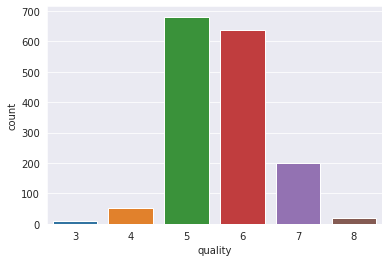

In [6]:
sns.countplot(x = 'quality', data=df)

In order to split our data into train, validation, and test sets, we need to separate out our inputs and outputs. 

Input X is all but the last column. Output y is the last column.

In [7]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

## Train - Validation - Test

To create the train-val-test split, we'll use `train_test_split()` from Sklearn. 

First we'll split our data into `train+val` and `test` sets. Then, we'll further split our `train+val` set to create our `train` and `val` sets. 

Because there's a "class" imbalance, we want to have equal distribution of all output classes in our train, validation, and test sets.

To do that, we use the `stratify` option in function `train_test_split()`.

Remember that stratification only works with classes, not numbers. So, in general, we can bin our numbers into classes using quartiles, deciles, histogram(`np.histogram()`) and so on. So, you would have to create a new dataframe which contains the output and it's "class". This "class" was obtained using the above mentioned methods.

In our case, let's use the numbers as is because they are already _like_ classes. After we split our data, we can convert the output to float (because regression).


In [8]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

Neural networks need data that lies between the range of (0,1). There's a ton of material available online on why we need to do it. 

To scale our values, we'll use the `MinMaxScaler()` from Sklearn. The `MinMaxScaler` transforms features by scaling each feature to a given range which is (0,1) in our case.

>     x_scaled = (x-min(x)) / (max(x)–min(x))

Notice that we use `.fit_transform()` on `X_train` while we use `.transform()` on `X_val` and `X_test`. 

We do this because we want to scale the validation and test set with the same parameters as that of the train set to avoid data leakage. `fit_transform` calculates scaling values and applies them while `.transform` only applies the calculated values.

In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

### Visualize Class Distribution in Train, Val, and Test

Once we've split our data into train, validation, and test sets, let's make sure the distribution of classes is equal in all three sets.

To do that, let's create a function called `get_class_distribution()`.
This function takes as input the obj `y` , ie. `y_train`, `y_val`, or `y_test`. Inside the function, we initialize a dictionary which contains the output classes as keys and their count as values. The counts are all initialized to 0. 

We then loop through our `y` object and update our dictionary.

In [11]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 3: 
            count_dict['rating_3'] += 1
        elif i == 4: 
            count_dict['rating_4'] += 1
        elif i == 5: 
            count_dict['rating_5'] += 1
        elif i == 6: 
            count_dict['rating_6'] += 1
        elif i == 7: 
            count_dict['rating_7'] += 1  
        elif i == 8: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Once we have the dictionary count, we use Seaborn library to plot the bar charts.

The make the plot, we first convert our dictionary to a dataframe using `pd.DataFrame.from_dict([get_class_distribution(y_train)])`.

Subsequently, we `.melt()` our convert our dataframe into the `long` format and finally use `sns.barplot()` to build the plots.

In [12]:
print("Train:", get_class_distribution(y_train))
print("Test :", get_class_distribution(y_test))
print("Val  :", get_class_distribution(y_val))

Train: {'rating_3': 7, 'rating_4': 38, 'rating_5': 490, 'rating_6': 459, 'rating_7': 143, 'rating_8': 14}
Test : {'rating_3': 2, 'rating_4': 11, 'rating_5': 136, 'rating_6': 128, 'rating_7': 40, 'rating_8': 3}
Val  : {'rating_3': 1, 'rating_4': 4, 'rating_5': 55, 'rating_6': 51, 'rating_7': 16, 'rating_8': 1}


Text(0.5, 1.0, 'Class Distribution in Test Set')

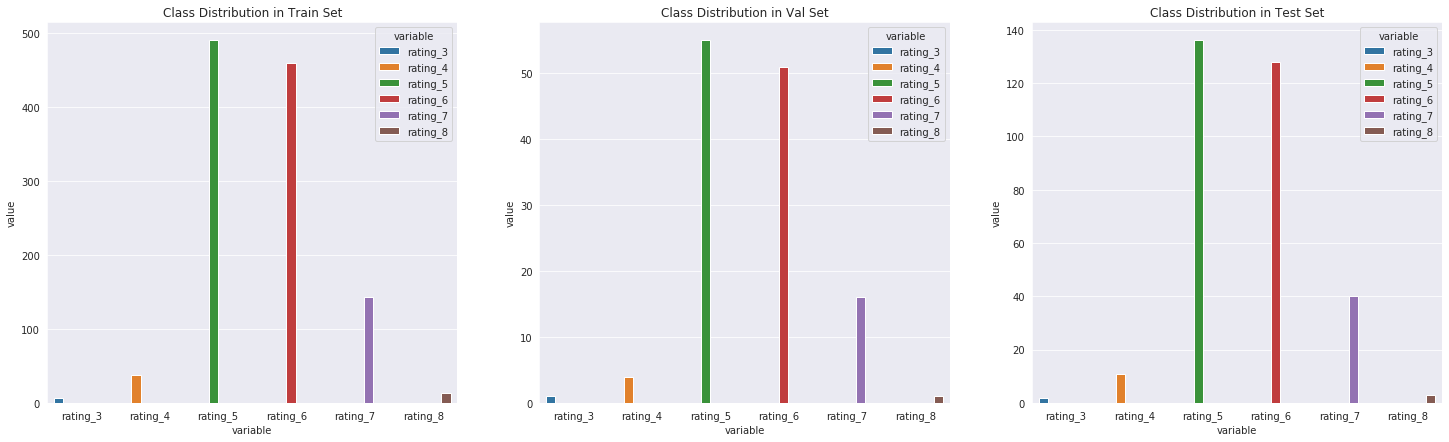

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

Convert output to `float`.

In [14]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

## Neural Network

### Define custom dataset

In [15]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

### Model Params

Before we proceed any further, let's define a few parameters that we'll use down the line.

In [16]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001

NUM_FEATURES = len(X.columns)

### Define Data Loader

In [17]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

### Define Neural Network Architecture

In [18]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)

        
        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)

        
        return (x)        

### Check for GPU

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Initialize the model, optimizer, and loss function. Transfer the model to GPU.

We are using the Mean Squared Error loss.

In [20]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=11, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


### Train

Before we start our training, let's define a dictionaries which will store the loss/epoch for both train and validation sets.

In [21]:
loss_stats = {
    'train': [],
    "val": []
}

You can see we've put a model.train() at the before the loop. `model.train()` tells PyTorch that you're in training mode. Well, why do we need to do that? If you're using layers such as `Dropout` or `BatchNorm` which behave differently during training and evaluation (for eample; not use dropout during evalualtion), you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, so, you don't explicitly have to write that. But it's good practice.

Similarly, we'll call `model.eval()` when we test our model. We'll see that below. Back to training; we start a _for-loop_. At the top of this _for-loop_, we initialize our `loss` and per epoch to 0. After every epoch, we'll print out the loss and reset it back to 0.

Then we have another _for-loop_. This _for-loop_ is used to get our data in batches from the `train_loader`.

We do `optimizer.zero_grad()` before we make any predictions. Since the `backward()` function accumulates gradients, we need to set it to 0 manually per mini-batch. From our defined model, we then obtain a prediction, get the loss for that mini-batch, perform backpropagation using `loss.backward()` and `optimizer.step()`.  Finally, we add all the mini-batch losses to obtain the average loss for that epoch. We add up all the losses for each minibatch and finally divide it by the number of minibatches ie. length of trainloader to obtain the average loss/accuracy per epoch.

The procedure we follow for training is the exact same for validation except for the fact that we wrap it up in torch.no_grad and not perform any backpropagation. `torch.no_grad()` tells PyTorch that we do not want to perform back-propagation, which reduces memory usage and speeds up computation.

In [22]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')        

Begin training.


Epoch 001: | Train Loss: 31.22514 | Val Loss: 30.50931
Epoch 002: | Train Loss: 30.02529 | Val Loss: 28.97327
Epoch 003: | Train Loss: 27.88010 | Val Loss: 25.89581
Epoch 004: | Train Loss: 23.50889 | Val Loss: 19.79879
Epoch 005: | Train Loss: 15.56384 | Val Loss: 9.91873
Epoch 006: | Train Loss: 5.49825 | Val Loss: 1.64401
Epoch 007: | Train Loss: 1.04008 | Val Loss: 1.23942
Epoch 008: | Train Loss: 0.92445 | Val Loss: 0.94137
Epoch 009: | Train Loss: 0.82020 | Val Loss: 0.91441
Epoch 010: | Train Loss: 0.80620 | Val Loss: 0.89953
Epoch 011: | Train Loss: 0.79084 | Val Loss: 0.87788
Epoch 012: | Train Loss: 0.77065 | Val Loss: 0.84902
Epoch 013: | Train Loss: 0.75632 | Val Loss: 0.83048
Epoch 014: | Train Loss: 0.74059 | Val Loss: 0.81050
Epoch 015: | Train Loss: 0.72692 | Val Loss: 0.78730
Epoch 016: | Train Loss: 0.71349 | Val Loss: 0.76783
Epoch 017: | Train Loss: 0.69864 | Val Loss: 0.74767
Epoch 018: | Train Loss: 0.68463 | Val Loss: 0.73214
Epoch 019: | Train Loss: 0.67153 | Va

## Visualize Loss and Accuracy

To plot the loss line plots, we again create a dataframe from the `loss_stats` dictionary.

In [23]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

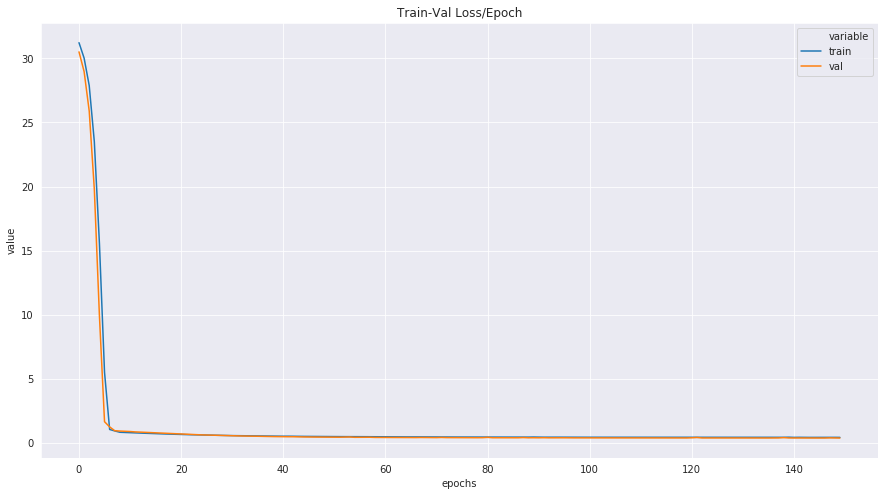

In [24]:
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

## Test

After training is done, we need to test how our model fared. Note that we've used `model.eval()` before we run our testing code.
To tell PyTorch that we do not want to perform back-propagation during inference, we use `torch.no_grad()`, just like we did it for the validation loop above.


In [25]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())

In [26]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [27]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.40861496703609534
R^2 : 0.36675687655886924
